In [1]:
import logging
logger = logging.getLogger(__name__)
for system in ['h5py._conv', 'matplotlib', 'PIL']:
     logging.getLogger(system).setLevel(logging.WARNING)
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import numpy as np
from dedalus import public as de

In [2]:
nz = 512
tol = 1e-3
IC = 'LBVP' # 'LBVP' -> compute LBVP, 'linear' (or else) -> use linear ICs
verbose = True
q_surface = 0.5

In [3]:
Lz = 1
Rayleigh = 1e6 #1e4
Prandtl = 1
Prandtlm = 1
#tau = #tau_Vallis*(Rayleigh*Prandtl)**(1/2)     #  condensation timescale

α = 3
β = 1.2
γ = 0.19
tau_Vallis = 5e-5
ΔT = -1

In [4]:
start_tau = 1e-3
stop_tau = 1e-5
taus = np.logspace(np.log10(start_tau), np.log10(stop_tau), num=10)

ks = [1e1, 1e3, 1e5, 1e7, 1e9]
ks = [1e3, 1e5, 1e7]

The non-dimensional tau timescale, relative to the thermal time, is:
\begin{equation}
    \tau = \tau_d \frac{\kappa}{H^2} = 5\times10^{-5}
\end{equation}
with $\tau_d$ the dimensional condensation time (Vallis et al 2019).

In buoyancy timescales,
\begin{align}
    \tau &= \tau_d \sqrt{\alpha \Delta T g} \\
    &= \tau_d \sqrt{\frac{\alpha \Delta T g H^4}{\kappa^2}} \frac{\kappa}{H^2} \\
    & = \sqrt{Ra Pr} \left(\tau_d \frac{\kappa}{H^2}\right) \\
    & = \sqrt{Ra Pr} \times \left(5\times10^{-5}\right) 
\end{align}
or, given $Ra \approx 10^{6}$
\begin{equation}
    \tau \approx 5 \times 10^{-3}
\end{equation}
This indicates that, in buoyancy time units, condensation is rapid compared to buoyant times.  Maybe too rapid.

Meanwhile, the quantity $P \tau$ is:
\begin{align}
    P \tau &= \frac{\sqrt{Ra Pr}}{\sqrt{Ra Pr}} \times \left(5\times10^{-5}\right) \\
    & = 5\times10^{-5}
\end{align}
Things probably don't get better if we multiply all terms through by P$\ldots$

In [5]:
P = 1                                 #  diffusion on buoyancy
S = (Prandtlm/Prandtl)**(-1/2)        #  diffusion on moisture

In [6]:
# Create bases and domain
coords = de.CartesianCoordinates('x', 'y', 'z')
dist = de.Distributor(coords, dtype=np.float64)
dealias = 2
zb = de.ChebyshevT(coords.coords[2], size=nz, bounds=(0, Lz), dealias=dealias)
z = zb.local_grid(1)

b = dist.Field(name='b', bases=zb)
q = dist.Field(name='q', bases=zb)

τb1 = dist.Field(name='τb1')
τb2 = dist.Field(name='τb2')
τq1 = dist.Field(name='τq1')
τq2 = dist.Field(name='τq2')

zb1 = zb.clone_with(a=zb.a+1, b=zb.b+1)
zb2 = zb.clone_with(a=zb.a+2, b=zb.b+2)
lift1 = lambda A, n: de.Lift(A, zb1, n)
lift = lambda A, n: de.Lift(A, zb2, n)

ex, ey, ez = coords.unit_vector_fields(dist)

k = 1e2 #3 #1e5 # cutoff for tanh
H = lambda A: 0.5*(1+np.tanh(k*A))

z_grid = dist.Field(name='z_grid', bases=zb)
z_grid['g'] = z

temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

tau = dist.Field(name='tau')

In [7]:
def plot_solution(solution, title=None, mask=None, linestyle=None, ax=None):
    b = solution['b']
    q = solution['q']
    m = solution['m']
    T = solution['T']
    rh = solution['rh']

    for f in [b, q, m, T, rh]:
        f.change_scales(1)
        
    if mask is None:
        mask = np.ones_like(z, dtype=bool)
    if ax is None:
        fig, ax = plt.subplots(ncols=2)
        markup = True
    else:
        for axi in ax:
            axi.set_prop_cycle(None)
        markup = False
    ax[0].plot(b['g'][mask],z[mask], label='$b$', linestyle=linestyle)
    ax[0].plot(γ*q['g'][mask],z[mask], label='$\gamma q$', linestyle=linestyle)
    ax[0].plot(m['g'][mask],z[mask], label='$b+\gamma q$', linestyle=linestyle)

    ax[1].plot(T['g'][mask],z[mask], label='$T$', linestyle=linestyle)
    ax[1].plot(q['g'][mask],z[mask], label='$q$', linestyle=linestyle)
    ax[1].plot(rh['g'][mask],z[mask], label='$r_h$', linestyle=linestyle)
    
    if markup:
        ax[1].legend()
        ax[0].legend()
        ax[0].set_ylabel('z')
        if title:
            ax[0].set_title(title)
    return ax

In [8]:
from scipy.optimize import newton
from scipy.interpolate import interp1d

def find_zc(sol, ε=1e-3, root_finding = 'inverse'):
    rh = sol['rh']
    rh.change_scales(1)
    f = interp1d(z[0,0,:], rh['g'][0,0,:])
    if root_finding == 'inverse':
        # invert the relationship and use interpolation to find where r_h = 1-ε (approach from below)
        f_i = interp1d(rh['g'][0,0,:], z[0,0,:]) #inverse
        zc = f_i(1-ε)
    elif root_finding == 'discrete':
        # crude initial emperical zc; look for where rh-1 ~ 0, in lower half of domain.
        zc = z[0,0,np.argmin(np.abs(rh['g'][0,0,0:int(nz/2)]-1))]
#    if zc is None:
#        zc = 0.2
#    zc = newton(f, 0.2)
    return zc

2022-10-20 21:14:45,465 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+01/s
b: 1.4e-17 -- 0.2
q: 0.5 -- 0.05
LBVP zc = 0.487


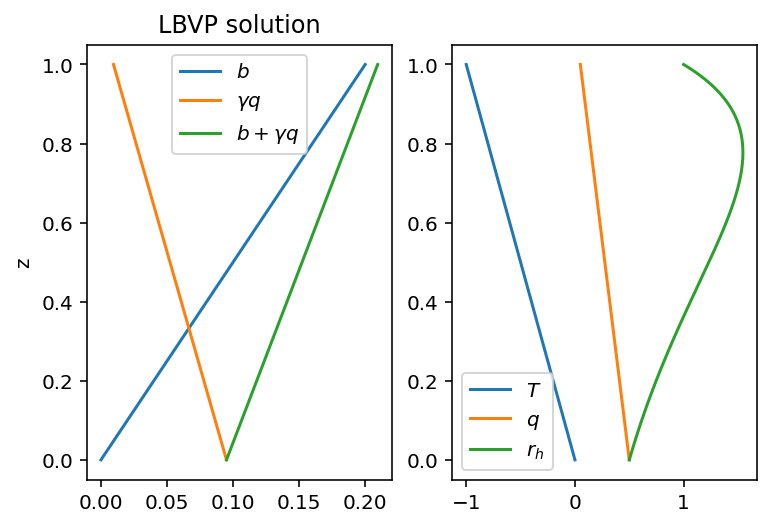

In [9]:
if IC == 'LBVP':
    dt = lambda A: 0*A
    # Stable linear solution as an intial guess
    problem = de.LBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
    problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = 0')
    problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = 0')
    problem.add_equation('b(z=0) = 0')
    problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
    problem.add_equation('q(z=0) = q_surface')
    problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')
    solver = problem.build_solver()
    solver.solve()
else:
    b['g'] = (β + ΔT)*z
    q['g'] = (1-z+np.exp(α*ΔT))
    
print('b: {:.2g} -- {:.2g}'.format(b(z=0).evaluate()['g'][0,0,0], b(z=Lz).evaluate()['g'][0,0,0]))
print('q: {:.2g} -- {:.2g}'.format(q(z=0).evaluate()['g'][0,0,0], q(z=Lz).evaluate()['g'][0,0,0]))

LBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
if verbose:
    plot_solution(LBVP_sol, title='LBVP solution')
if IC == 'LBVP':
    zc = find_zc(LBVP_sol)
    print('LBVP zc = {:.3}'.format(zc))
    LBVP_sol['zc'] = zc

In [10]:
dt = lambda A: 0*A

# Stable nonlinear solution
problem = de.NLBVP([b, q, τb1, τb2, τq1, τq2], namespace=locals())
problem.add_equation('dt(b) - P*lap(b) + lift(τb1, -1) + lift(τb2, -2) = γ*H(q-qs)*(q-qs)/tau')
problem.add_equation('dt(q) - S*lap(q) + lift(τq1, -1) + lift(τq2, -2) = - H(q-qs)*(q-qs)/tau')
problem.add_equation('b(z=0) = 0')
problem.add_equation('b(z=Lz) = β + ΔT') # technically β*Lz
problem.add_equation('q(z=0) = q_surface*qs(z=0)')
problem.add_equation('q(z=Lz) = np.exp(α*ΔT)')

In [11]:
for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

NLBVP_library = {}
# Relax on tau
for tau_i in taus:
    tau['g'] = tau_i
    # Relax on k
    for i, k in enumerate(ks):
        solver = problem.build_solver()
        pert_norm = np.inf
        while pert_norm > tol:
            solver.newton_iteration()
            pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
            logger.info("tau = {:.1g}, k = {:.0g}, L2 err = {:.1g}".format(tau['g'][0,0,0], k, pert_norm))
        NLBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
        zc = find_zc(NLBVP_sol)
        logger.info('tau = {:.1g}, k = {:.0g}, zc = {:.2g}'.format(tau['g'][0,0,0], k, zc))
        NLBVP_sol['zc'] = zc
        
        # store in library of solutions
        if i == 0:
            NLBVP_library[tau_i] = {}
        NLBVP_library[tau_i][k] = NLBVP_sol

2022-10-20 21:15:43,681 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, L2 err = 0.06
2022-10-20 21:15:54,954 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, L2 err = 0.008
2022-10-20 21:16:00,992 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, L2 err = 0.005
2022-10-20 21:16:06,061 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, L2 err = 0.001
2022-10-20 21:16:10,635 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, L2 err = 0.0002
2022-10-20 21:16:10,638 __main__ 0/1 INFO :: tau = 0.001, k = 1e+03, zc = 0.49
2022-10-20 21:16:15,080 __main__ 0/1 INFO :: tau = 0.001, k = 1e+05, L2 err = 3e-06
2022-10-20 21:16:15,082 __main__ 0/1 INFO :: tau = 0.001, k = 1e+05, zc = 0.49
2022-10-20 21:16:19,367 __main__ 0/1 INFO :: tau = 0.001, k = 1e+07, L2 err = 6e-10
2022-10-20 21:16:19,369 __main__ 0/1 INFO :: tau = 0.001, k = 1e+07, zc = 0.49
2022-10-20 21:16:24,178 __main__ 0/1 INFO :: tau = 0.0006, k = 1e+03, L2 err = 0.004
2022-10-20 21:16:29,638 __main__ 0/1 INFO :: tau = 0.0006, k = 1e+03, L2 err = 0.0006
2022

2022-10-20 21:52:30,344 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.1
2022-10-20 21:53:55,424 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.1
2022-10-20 21:55:03,682 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.2
2022-10-20 21:56:02,847 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.06
2022-10-20 21:56:59,899 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.01
2022-10-20 21:57:55,122 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.003
2022-10-20 21:58:55,987 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, L2 err = 0.0003
2022-10-20 21:58:55,991 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+03, zc = 0.18
2022-10-20 21:59:49,285 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+05, L2 err = 3e-05
2022-10-20 21:59:49,288 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+05, zc = 0.18
2022-10-20 22:01:08,509 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+07, L2 err = 4e-06
2022-10-20 22:01:08,513 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+07, zc = 0.18


In [12]:
NLBVP_sol = NLBVP_library[taus[-1]][ks[-1]]#{'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}

array([<AxesSubplot:title={'center':'NLBVP solution'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

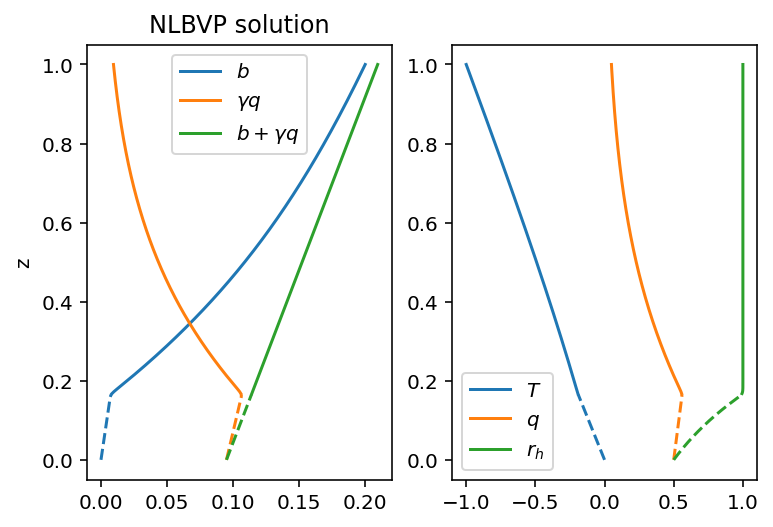

In [13]:
value = rh.evaluate()
value.change_scales(1)
mask = (value['g'] >= 1-0.01)
ax = plot_solution(NLBVP_sol, title='NLBVP solution', mask=mask, linestyle='solid')
mask = (value['g'] < 1-0.01)
plot_solution(NLBVP_sol, title='NLBVP solution', mask=mask, linestyle='dashed', ax=ax)

Text(0.5, 1.0, '$\\gamma$ = 0.19, $\\beta$ = 1.2, $\\tau$ = 1e-05')

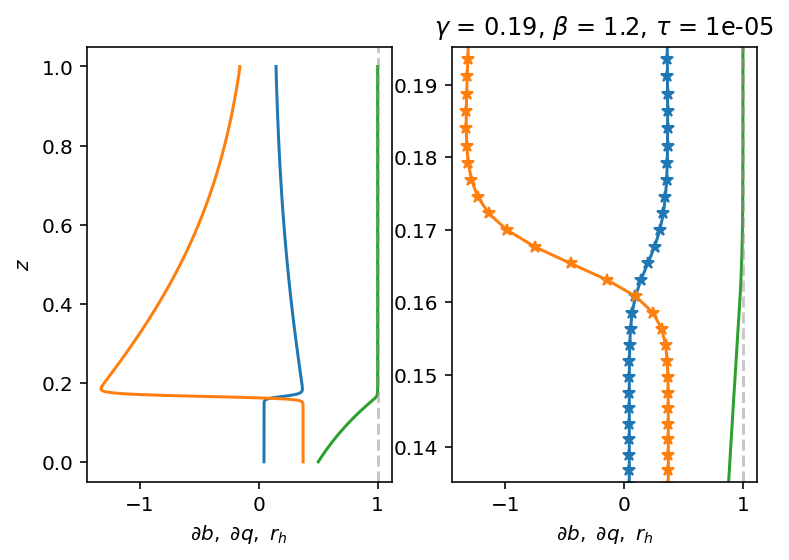

In [14]:
dz = lambda A: de.Differentiate(A, coords['z'])
dbdz = dz(NLBVP_sol['b']).evaluate()
dqdz = dz(NLBVP_sol['q']).evaluate()
dbdz.change_scales(1)
dqdz.change_scales(1)
NLBVP_sol['rh'].change_scales(1)
fig, ax = plt.subplots(ncols=2)
ax[0].plot(dbdz['g'][0,0,:], z[0,0,:])
ax[0].plot(dqdz['g'][0,0,:], z[0,0,:])
ax[0].plot(NLBVP_sol['rh']['g'][0,0,:], z[0,0,:])
ax[0].axvline(x=1, color='xkcd:grey', linestyle='dashed', alpha=0.5)
ax[0].set_xlabel('$\partial b,~\partial q,~r_h$')
ax[0].set_ylabel('$z$')
ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], marker='*')
ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], marker='*')
ax[1].plot(NLBVP_sol['rh']['g'][0,0,:], z[0,0,:])
zc = NLBVP_sol['zc']
ax[1].axvline(x=1, color='xkcd:grey', linestyle='dashed', alpha=0.5)
ax[1].set_ylim(zc-0.04, zc+0.02)
ax[1].set_xlabel('$\partial b,~\partial q,~r_h$')
ax[1].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:.1g}'.format(γ,β, tau['g'][0,0,0]))

[0.001, 0.0005994842503189409, 0.00035938136638046257, 0.00021544346900318845, 0.0001291549665014884, 7.742636826811278e-05, 4.641588833612782e-05, 2.782559402207126e-05, 1.6681005372000593e-05, 1e-05]


Text(0.5, 1.0, '$\\gamma$ = 0.19, $\\beta$ = 1.2, $\\tau$ = 1e-05')

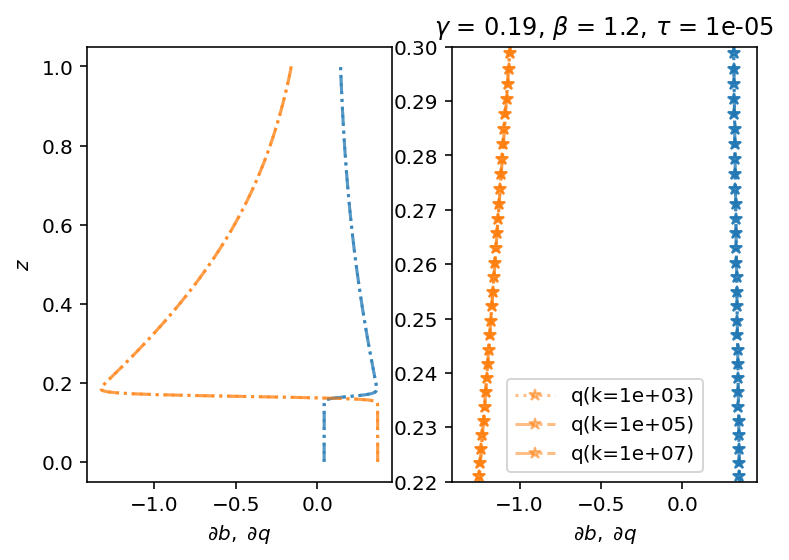

In [15]:
dz = lambda A: de.Differentiate(A, coords['z'])
taus = [k for k in NLBVP_library]
print(taus)
tau_i = taus[-1]
fig, ax = plt.subplots(ncols=2)
linestyles=['dotted', 'dashdot','dashdot','dashed', 'solid']
for i, k in enumerate(NLBVP_library[tau_i]):
    lib = NLBVP_library[tau_i]
    dbdz = dz(lib[k]['b']).evaluate()
    dqdz = dz(lib[k]['q']).evaluate()
    dbdz.change_scales(1)
    dqdz.change_scales(1)
    ax[0].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
    ax[0].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
    ax[0].set_xlabel('$\partial b,~\partial q$')
    ax[0].set_ylabel('$z$')
    ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], marker='*', alpha=0.5, linestyle=linestyles[i])#, label='b(k={:.1g})'.format(k))
    ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], marker='*', alpha=0.5, linestyle=linestyles[i], label='q(k={:.1g})'.format(k))
    ax[1].set_ylim(0.22, 0.30)
    ax[1].set_xlabel('$\partial b,~\partial q$')
    ax[0].set_prop_cycle(None)
    ax[1].set_prop_cycle(None)
ax[1].legend()
ax[1].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\tau$ = {:.1g}'.format(γ,β, tau_i))

[0.001, 0.0005994842503189409, 0.00035938136638046257, 0.00021544346900318845, 0.0001291549665014884, 7.742636826811278e-05, 4.641588833612782e-05, 2.782559402207126e-05, 1.6681005372000593e-05, 1e-05]


Text(0.5, 1.0, '$\\tau$ = 0.001--1e-05 and $k$ = 1e+03--1e+07')

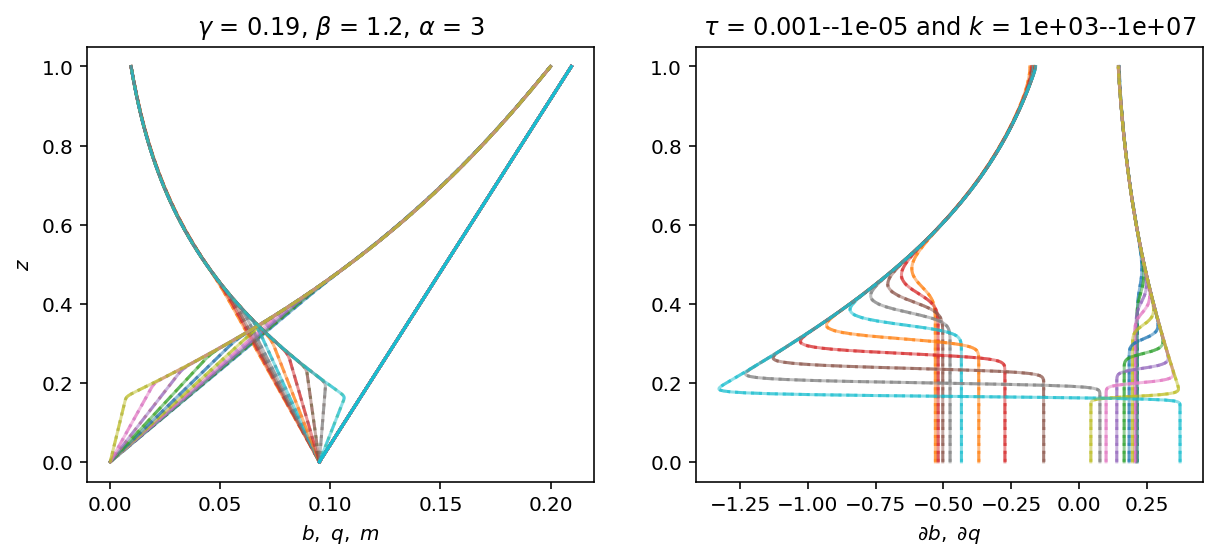

In [16]:
dz = lambda A: de.Differentiate(A, coords['z'])
taus = [k for k in NLBVP_library]
ks = [k for k in NLBVP_library[taus[0]]]
print(taus)
fig, ax = plt.subplots(ncols=2, figsize=[10, 4])
for tau_i in taus:
    linestyles=['dotted', 'dashdot','dashdot','dashed', 'solid']
    linestyles=['dotted', 'dashed', 'solid']
    for i, k in enumerate(NLBVP_library[tau_i]):
        lib = NLBVP_library[tau_i]
        b.change_scales(1)
        q.change_scales(1)
        lib[k]['b'].change_scales(1)
        lib[k]['q'].change_scales(1)
        b['g'] = lib[k]['b']['g']
        q['g'] = lib[k]['q']['g']
        dbdz = dz(b).evaluate()
        dqdz = dz(q).evaluate()
        dbdz.change_scales(1)
        dqdz.change_scales(1)
        b.change_scales(1)
        q.change_scales(1)
        if i == 0:
            p1 = ax[0].plot(b['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
            p2 = ax[0].plot(γ*q['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
            p3 = ax[0].plot(b['g'][0,0,:]+γ*q['g'][0,0,:], z[0,0,:])
            p1 = ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
            p2 = ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
        else:
            ax[0].plot(b['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p1[0].get_color())
            ax[0].plot(γ*q['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p2[0].get_color())
            ax[0].plot(b['g'][0,0,:]+γ*q['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p3[0].get_color())
            ax[1].plot(dbdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p1[0].get_color())
            ax[1].plot(dqdz['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p2[0].get_color())

ax[0].set_xlabel('$b,~q,~m$')

ax[1].set_xlabel('$\partial b,~\partial q$')
ax[0].set_ylabel('$z$')
ax[0].set_title(r'$\gamma$ = {:}, $\beta$ = {:}, $\alpha$ = {:}'.format(γ,β,α))
ax[1].set_title(r'$\tau$ = {:.1g}--{:.1g} and $k$ = {:.1g}--{:.1g}'.format(taus[0], taus[-1], ks[0], ks[-1]))

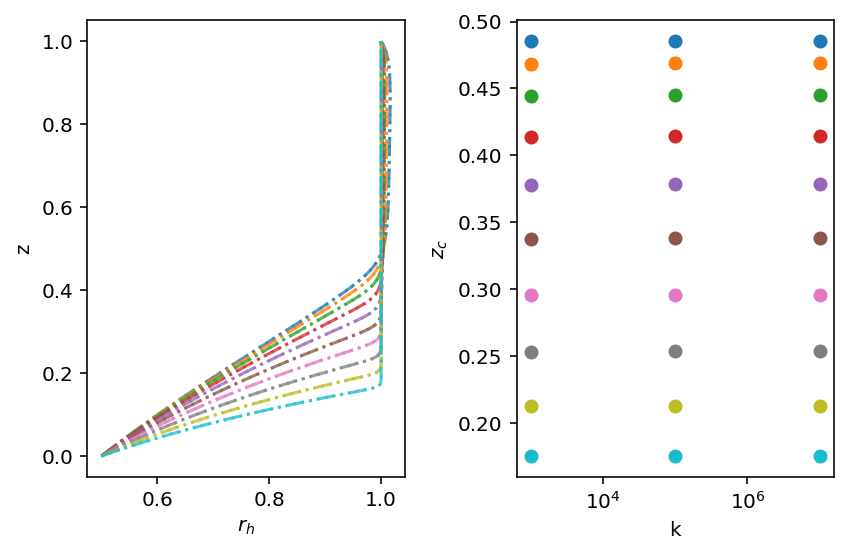

In [17]:
fig, ax = plt.subplots(ncols=2)
for tau_i in taus:
    zcs=[]
    ks=[]
    zc = None
    linestyles=['dotted', 'dashdot','dashdot','dashed', 'solid']
    for i, k in enumerate(NLBVP_library[tau_i]):
        lib = NLBVP_library[tau_i]
        sol = lib[k]
        rh = sol['rh']
        rh.change_scales(1)
        if i == 0:
            p1 = ax[0].plot(rh['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i])
        else:
            ax[0].plot(rh['g'][0,0,:], z[0,0,:], alpha=0.5, linestyle=linestyles[i], color=p1[0].get_color())
        zc = find_zc(sol)
        lib[k]['zc']= zc
        zcs.append(zc)
        ks.append(k)
    ax[1].scatter(ks, zcs)
    ax[1].set_xscale('log')
ax[0].set_xlabel('$r_h$')
ax[0].set_ylabel('z')
ax[1].set_xlabel('k')
ax[1].set_ylabel('$z_c$')
fig.tight_layout()

In [18]:
print('diffusion timescale tau')
print('Vallis: {:.2g}'.format(tau_Vallis))
print('us:     {:.2g}'.format(tau['g'][0,0,0]*P))
print('buoyancy timescale tau')
print('Vallis: {:.2g}'.format(tau_Vallis/P))
print('us:     {:.2g}'.format(tau['g'][0,0,0]))


diffusion timescale tau
Vallis: 5e-05
us:     1e-05
buoyancy timescale tau
Vallis: 5e-05
us:     1e-05


Hysteresis testing
==============

Let's see if hysteresis is a major problem, by walking down in tau along the high-k space, and then walking a solution back up in tau, starting each time from our libary of solutions.

Test 1: walk down in tau

2022-10-20 22:01:19,003 __main__ 0/1 INFO :: tau = 0.001, k = 1e+05, L2 err = 7e-05
2022-10-20 22:01:19,008 __main__ 0/1 INFO :: tau = 0.001, k = 1e+05, zc = 0.49
2022-10-20 22:01:25,717 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.09
2022-10-20 22:01:47,138 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.1
2022-10-20 22:02:03,914 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.02
2022-10-20 22:02:20,765 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.004
2022-10-20 22:02:31,782 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.003
2022-10-20 22:02:43,290 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.002
2022-10-20 22:02:54,611 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.001
2022-10-20 22:03:05,453 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, L2 err = 0.0002
2022-10-20 22:03:05,455 __main__ 0/1 INFO :: tau = 0.0002, k = 1e+05, zc = 0.41
2022-10-20 22:03:14,679 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.

array([<AxesSubplot:title={'center':'hysteresis test 1: walk $\\tau$ = 0.001--1e-05'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

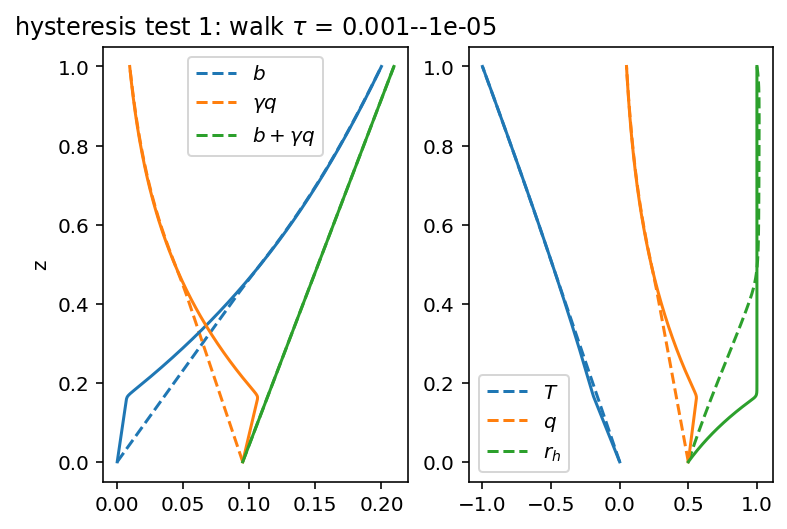

In [19]:
taus = [k for k in NLBVP_library]
start_tau = taus[0]
stop_tau  = taus[-1]
start_k = 1e5

start_sol = NLBVP_library[start_tau][start_k]
ax = plot_solution(start_sol, title=r'hysteresis test 1: walk $\tau$ = {:.2g}--{:.2g}'.format(start_tau, stop_tau), linestyle='dashed')

b.change_scales(1)
q.change_scales(1)
start_sol['b'].change_scales(1)
start_sol['q'].change_scales(1)
b['g'] = start_sol['b']['g']
q['g'] = start_sol['q']['g']
temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

# Relax on tau
for tau_i in np.logspace(np.log10(start_tau), np.log10(stop_tau), num=4):
    tau['g'] = tau_i
    k = start_k
    solver = problem.build_solver()
    pert_norm = np.inf
    while pert_norm > tol:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info("tau = {:.1g}, k = {:.0g}, L2 err = {:.1g}".format(tau['g'][0,0,0], k, pert_norm))
    sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
    zc = find_zc(sol)
    logger.info('tau = {:.1g}, k = {:.0g}, zc = {:.2g}'.format(tau['g'][0,0,0], k, zc))
NLBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
plot_solution(NLBVP_sol, linestyle='solid', ax=ax)

array([<AxesSubplot:title={'center':'hysteresis test 1: start state'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

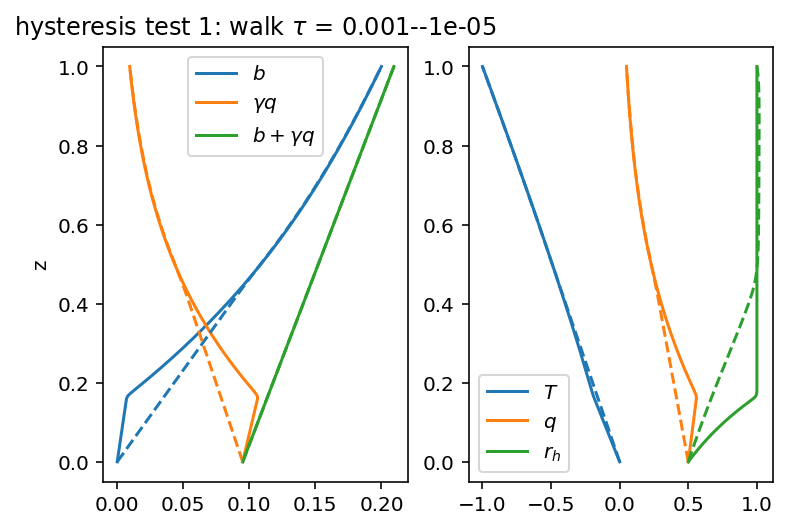

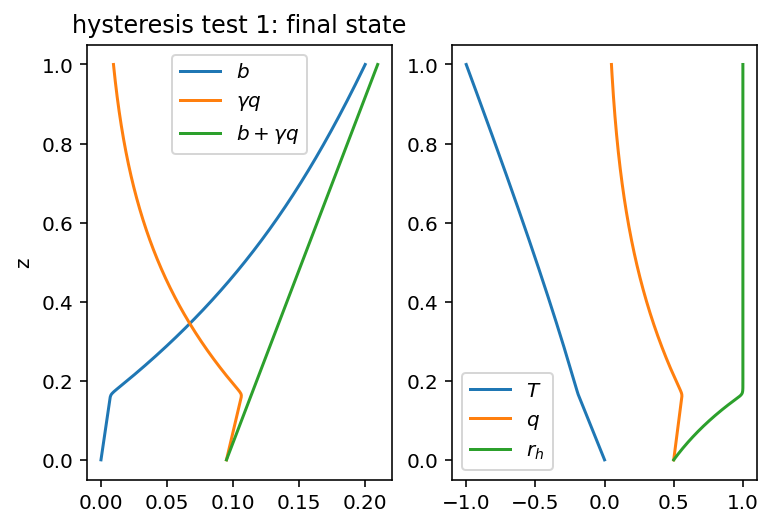

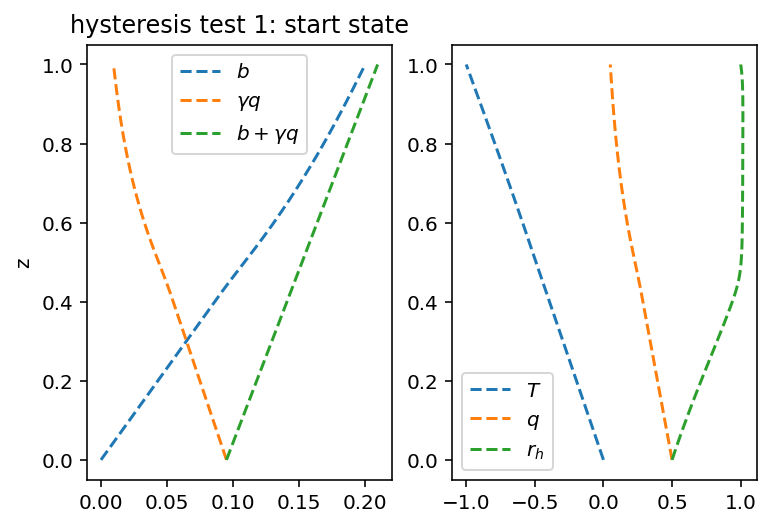

In [20]:
ax = plot_solution(NLBVP_sol, title=r'hysteresis test 1: walk $\tau$ = {:.2g}--{:.2g}'.format(start_tau, stop_tau), linestyle='solid')
plot_solution(start_sol, linestyle='dashed', ax=ax)

plot_solution(NLBVP_sol, title='hysteresis test 1: final state', linestyle='solid')
plot_solution(start_sol, title='hysteresis test 1: start state', linestyle='dashed')

Test 2: walk up in tau

2022-10-20 22:13:39,749 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+05, L2 err = 3e-05
2022-10-20 22:13:39,752 __main__ 0/1 INFO :: tau = 1e-05, k = 1e+05, zc = 0.18
2022-10-20 22:14:31,479 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.01
2022-10-20 22:15:05,913 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.02
2022-10-20 22:15:38,354 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.01
2022-10-20 22:16:08,937 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.009
2022-10-20 22:16:41,006 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.007
2022-10-20 22:17:10,932 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.006
2022-10-20 22:17:39,869 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.005
2022-10-20 22:18:07,869 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.004
2022-10-20 22:18:35,285 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.003
2022-10-20 22:19:00,532 __main__ 0/1 INFO :: tau = 5e-05, k = 1e+05, L2 err = 0.002


array([<AxesSubplot:title={'center':'hysteresis test 2: walk $\\tau$ = 1e-05--0.001'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

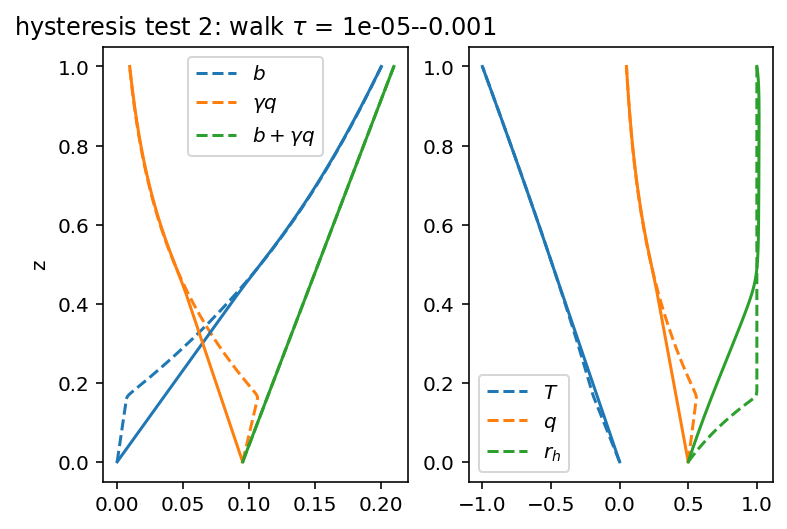

In [21]:
taus = [k for k in NLBVP_library]
start_tau = taus[-1]
stop_tau  = taus[0]
start_k = 1e5
start_sol = NLBVP_library[start_tau][start_k]
ax = plot_solution(NLBVP_sol, title=r'hysteresis test 2: walk $\tau$ = {:.2g}--{:.2g}'.format(start_tau, stop_tau), linestyle='dashed')

b.change_scales(1)
q.change_scales(1)
start_sol['b'].change_scales(1)
start_sol['q'].change_scales(1)
b['g'] = start_sol['b']['g']
q['g'] = start_sol['q']['g']
temp = b - β*z_grid
temp.name = 'T'

qs = np.exp(α*temp)
rh = q*np.exp(-α*temp)

for system in ['subsystems']:
     logging.getLogger(system).setLevel(logging.WARNING)

# Relax on tau
for tau_i in np.logspace(np.log10(start_tau), np.log10(stop_tau), num=4):
    tau['g'] = tau_i
    k = start_k
    solver = problem.build_solver()
    pert_norm = np.inf
    while pert_norm > tol:
        solver.newton_iteration()
        pert_norm = sum(pert.allreduce_data_norm('c', 2) for pert in solver.perturbations)
        logger.info("tau = {:.1g}, k = {:.0g}, L2 err = {:.1g}".format(tau['g'][0,0,0], k, pert_norm))
    sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
    zc = find_zc(sol)
    logger.info('tau = {:.1g}, k = {:.0g}, zc = {:.2g}'.format(tau['g'][0,0,0], k, zc))
NLBVP_sol = {'b':b.copy(), 'q':q.copy(), 'm':(b+γ*q).evaluate().copy(), 'T':temp.evaluate().copy(), 'rh':rh.evaluate().copy()}
plot_solution(NLBVP_sol, linestyle='solid', ax=ax)

array([<AxesSubplot:title={'center':'hysteresis test 2: start state'}, ylabel='z'>,
       <AxesSubplot:>], dtype=object)

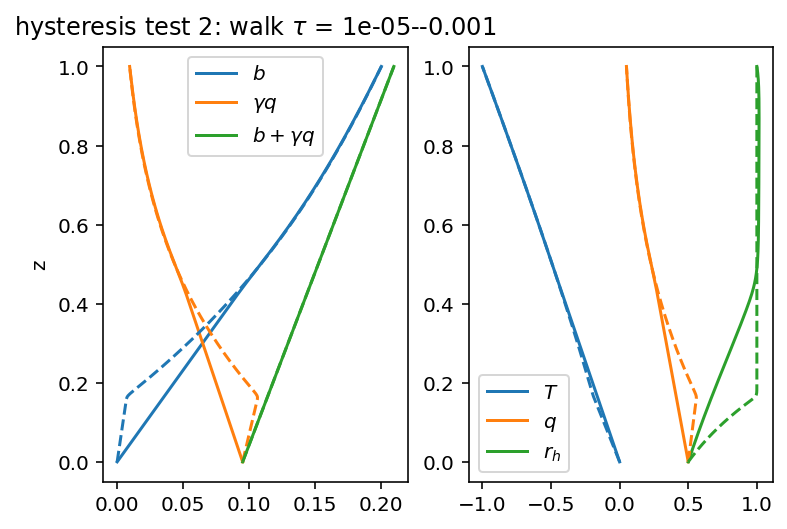

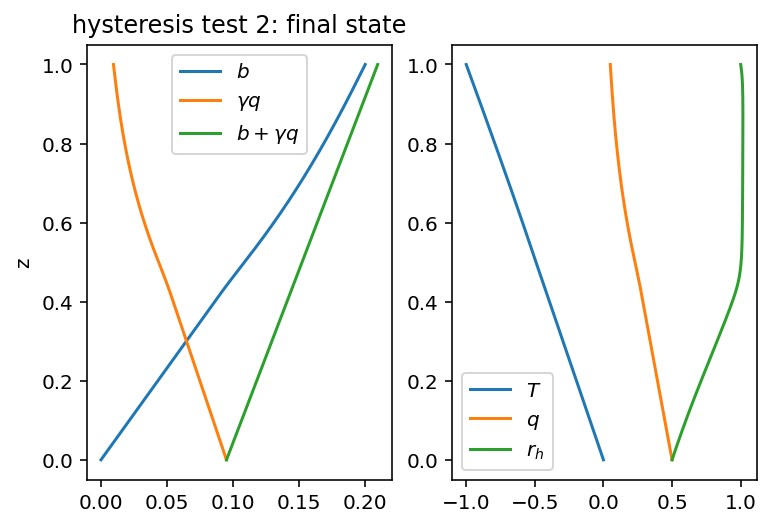

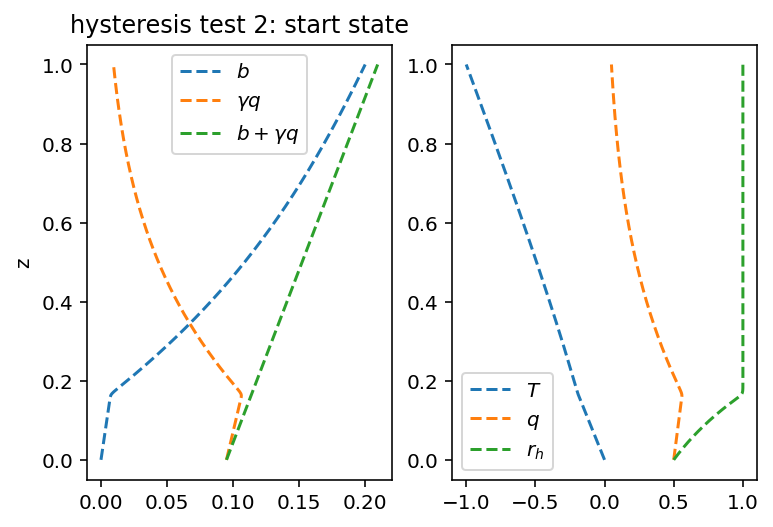

In [22]:
ax = plot_solution(NLBVP_sol, title=r'hysteresis test 2: walk $\tau$ = {:.2g}--{:.2g}'.format(start_tau, stop_tau), linestyle='solid')

plot_solution(start_sol, linestyle='dashed', ax=ax)

plot_solution(NLBVP_sol, title='hysteresis test 2: final state', linestyle='solid')
plot_solution(start_sol, title='hysteresis test 2: start state', linestyle='dashed')

Summary on hysterisis
==================
At loose tolerances (`tol=1e-2`), we saw evidence of hysteretic behaviour.  Walking down in tau at fixed k (`k=1e5`) lead to different solutions than walking up in tau.  At loose tolerances, `zc(tau, k)` shows structure in both tau and k.

If the tolerances are sufficiently tight (`tol=1e-3`), all evidence of this hysteretic behaviour goes away.  Additionally, `zc(tau, k) = zc(tau)`, e.g. there's only structure in the tau dimension.

At `tol=1e-3`, the solution time to build the initial library is about 10 minutes on a Macbook Pro M1, which is about double the time at looser tolerances, but very reasonable.

WIP
======
Everything below here works for saturated atmospheres, but we need to figure out how to do the unsaturated lower atmosphere and matching $z_c$ conditions.


Analytic solutions
---------------------
For saturated atmospheres, we can construct an analytic function using Lambert W functions and following the discussion in section 5.1.

Things are a bit more complicated in a partially unsaturated atmosphere.  In that atmosphere, we need to construct a linear $q$ and $b$ profile until we hit $z_c$ where $q(z_c) = q_s(z_c)$, and then we proceed with the Lambert W solution.

Assume we start at $q(z=0) = q_0$ and $b(z=0)=b_0$, and that both $q$ and $b$ have linear profiles:
\begin{align}
    q(z) & = q_0 + Q z \\
    b(z) & = b_0 + B z \\
    T(z) & = b(z) - \beta z = b_0 + (B-\beta) z
\end{align}
They note that at $z=z_c$, $q$, $b$, $\partial_z q$ and $\partial_z b$ are all continuous, and this can be used (numerically) to solve for $z_c$.  Okay.

Meanwhile,
\begin{align}
q_s(z) = \exp{(\alpha T)} = \exp{(\alpha (b_0 + (B-\beta) z)}
\end{align}
and
\begin{align}
    q(z_c) &= q_s(z_c) \\
    q_0 + Q z_c &= \exp{(\alpha (b_0 + (B-\beta) z_c)}
\end{align}
We could rootfind on this for z_c if we knew $Q$ and $B$.  Hmm...


At $z_c$ we know:

from the bottom:
\begin{align}
b(z_c-) &= b_0 + B z_c \\
\partial b(z_c-) &= B
\end{align}
(whoa, B!=0, so that's inconsistent with 5.14, which said that $\partial b(z_c) = 0$)

oh, okay, (5.14) actually says:
\begin{align}
\partial q(z_c+) - \partial q(z_c-) = 0
\end{align}
ok!

And $T = b - \beta z$ (eq 4.9) so $b = T + \beta z$, and the upper solution is:
\begin{align}
T(z_c+) & = P + (Q-\beta) z_c+ - \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha}
\end{align}
or
\begin{align}
b(z_c+) & = P + Q z_c+ - \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha} \\
\partial b(z_c+) & = Q - \partial \frac{W(\alpha \gamma \exp(\alpha(P+(Q-\beta) z_c+)))}{\alpha}
\end{align}

Now, where are things complicated.

In [23]:
from scipy.special import lambertw as W
def compute_analytic(z_in):
    z = dist.Field(bases=zb)
    z['g'] = z_in

    b1 = 0
    b2 = β + ΔT
    q1 = q_surface
    q2 = np.exp(α*ΔT)

    P = b1 + γ*q1
    Q = ((b2-b1) + γ*(q2-q1))
    
    C = P + (Q-β)*z['g']
    
    m = (P+Q*z).evaluate()
    T = dist.Field(bases=zb)
    T['g'] = C - W(α*γ*np.exp(α*C)).real/α
    b = (T + β*z).evaluate()
    q = ((m-b)/γ).evaluate()
    rh = (q*np.exp(-α*T)).evaluate()
    return {'b':b, 'q':q, 'm':m, 'T':T, 'rh':rh}